# Classificador de Emoções em Texto com Embeddings e BERT

In [11]:
#%pip install -U accelerate

In [12]:
import accelerate
print(accelerate.__version__)

1.5.2


In [13]:
# Bibliotecas

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import classification_report, confusion_matrix
from datasets import load_dataset
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [14]:
# Carregar dataset
dataset = load_dataset('emotion')

In [15]:
# Tokenização
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
  return tokenizer(examples["text"], truncation=True, padding='max_length')

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [16]:
# Carregar modelo BERT para classificação de texto
num_labels = dataset['train'].features['label'].num_classes
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Argumentos de treinamento
training_args = TrainingArguments(
  evaluation_strategy='epoch',
  output_dir='./resultados',
  save_strategy='epoch',
  learning_rate=2e-5,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=64,
  num_train_epochs=3,
  weight_decay=0.01,
  logging_dir='./logs',
  load_best_model_at_end=True,
  metric_for_best_model='accuracy',
  logging_steps=10
)

In [18]:
# Função de métricas
def compute_metrics(pred):
  preds = np.argmax(pred.predictions, axis=1)
  labels = pred.label_ids
  acc = np.mean(preds == labels)
  return {'accuracy': acc}

In [19]:
# Treinador
trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=tokenized_dataset['train'].select(range(250)),
  eval_dataset=tokenized_dataset['validation'].select(range(50)),
  compute_metrics=compute_metrics
)

In [20]:
# Treinamento do modelo
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.752300,1.569153,0.280000
2,1.522500,1.520042,0.280000
3,1.445400,1.502713,0.280000


TrainOutput(global_step=48, training_loss=1.569299340248108, metrics={'train_runtime': 1184.7549, 'train_samples_per_second': 0.633, 'train_steps_per_second': 0.041, 'total_flos': 197340378624000.0, 'train_loss': 1.569299340248108, 'epoch': 3.0})

In [21]:
# Avaliação no conjunto de teste
preds_output = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

In [23]:
# Relatório de classificação
print(classification_report(labels, preds,target_names=dataset["train"].features['label'].names))

              precision    recall  f1-score   support

     sadness       0.50      0.15      0.23       581
         joy       0.37      0.97      0.53       695
        love       0.00      0.00      0.00       159
       anger       0.00      0.00      0.00       275
        fear       0.00      0.00      0.00       224
    surprise       0.00      0.00      0.00        66

    accuracy                           0.38      2000
   macro avg       0.14      0.19      0.13      2000
weighted avg       0.27      0.38      0.25      2000



c:\Users\josaf\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\josaf\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\josaf\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

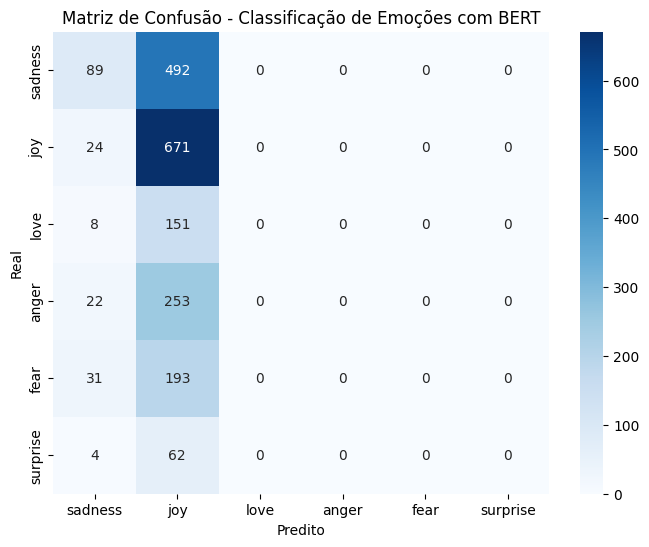

In [25]:
# Matriz de confusão
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset['train'].features['label'].names, yticklabels=dataset['train'].features['label'].names)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Classificação de Emoções com BERT")
plt.show()